In [1]:
"""
Author: Christina Chen
This Jupyter Notebook plots and fits individual events using the naive Monte Carlo method.
"""

'\nAuthor: Christina Chen\nThis Jupyter Notebook plots and fits individual events using the naive Monte Carlo method.\n'

In [2]:
import numpy as np
import pytpc
from pytpc.fitting.mcopt_wrapper import Tracker, EventGenerator, PadPlane, Minimizer
from pytpc.constants import *
import pytpc.simulation
import pytpc.tpcplot
import pytpc.vmedata
from pytpc.cleaning import HoughCleaner
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import scipy.signal
import h5py
from scipy.interpolate import UnivariateSpline, interp1d
from scipy.optimize import differential_evolution, minimize, basinhopping, leastsq
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import os
import yaml
from scipy.fftpack import fft, ifft, fftshift, ifftshift
from copy import copy, deepcopy
from pytpc.utilities import find_exclusion_region, read_lookup_table
import math
from effsim.paramgen import uniform_param_generator
from effsim.effsim import EventSimulator

/home/chen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/chen/anaconda3/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
with open('/home/chen/ar46/config/config_e15503b_p.yml', 'r') as f:
    config = yaml.load(f)

mcfitter = pytpc.fitting.MCFitter(config)

In [4]:
tilt = config['tilt'] * degrees 
padplane = mcfitter.padplane
efield = np.array(config['efield'])
bfield = np.array(config['bfield'])
mass_num = config['mass_num']
charge_num = config['charge_num']
gas = pytpc.gases.InterpolatedGas(config['gas_name'], config['gas_pressure'])
beam_enu0 = config['beam_enu0']
beam_charge = config['beam_charge']
beam_mass = config['beam_mass']
max_en = config['tracker_max_en']
vd = np.array(config['vd'])
max_beam_angle = (config['max_beam_angle']*math.pi)/180
beam_origin_z = config['beam_origin_z']

[ 232.43919284 -101.32819117  139.            6.21021669 5040.
    0.           64.82820425]


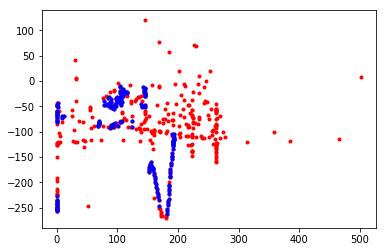

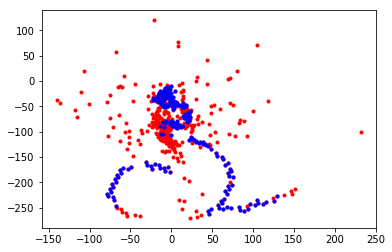

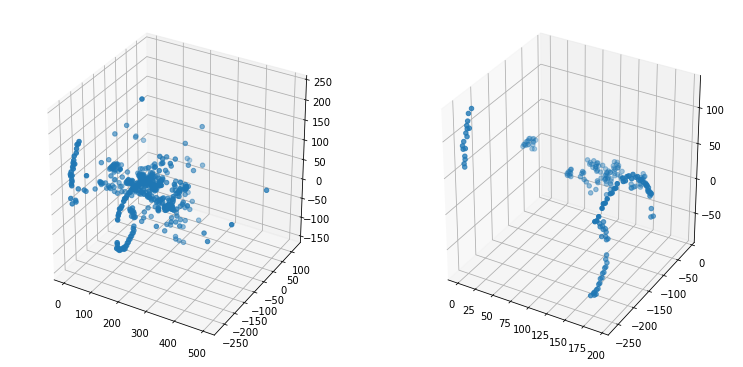

In [4]:
DETECTOR_LENGTH = 1250.0
DRIFT_VEL = 5.2
CLOCK = 12.5
full = h5py.File('/home/chen/ar46/clean_events/clean_run_0130.h5', 'r')
dataset_name = '/clean'
evt_full = full[dataset_name]

evt_ID = 329

xyzs_h5 = evt_full[str(evt_ID)]

xyzs = np.array(xyzs_h5)
print(xyzs[0])
#delete the points which are farther away from the center of the spiral
del_list = []
    
for point in xyzs:
    if (point[2] > DETECTOR_LENGTH):
        continue
            
for i in range(len(xyzs)):
    if (xyzs[i,6]) > 40.0:
        del_list.append(i)
    elif (xyzs[i][2])*CLOCK/DRIFT_VEL > 500.0:
        del_list.append(i)
    elif (xyzs[i][5] < 2.0): 
        del_list.append(i)         
cut_xyzs = np.delete(xyzs,del_list,axis=0)

xy = xyzs[:, 0:2]
xy_C = np.ascontiguousarray(xy, dtype=np.double)
cx, cy = pytpc.cleaning.hough_circle(xy_C)
#print(xyzs)
cut_xy = cut_xyzs[:, 0:2]
cut_xy_C = np.ascontiguousarray(cut_xy, dtype=np.double)
cut_cx, cut_cy = pytpc.cleaning.hough_circle(cut_xy_C)

%matplotlib inline
plt.plot(xyzs[:, 2], xyzs[:, 1], 'r.')
plt.plot(cut_xyzs[:, 2], cut_xyzs[:, 1], 'b.')
plt.show()
plt.plot(xyzs[:, 0], xyzs[:, 1], 'r.')
plt.plot(cut_xyzs[:, 0], cut_xyzs[:, 1], 'b.')
plt.show()

fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(xyzs[:,2],xyzs[:,1],xyzs[:,0])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(cut_xyzs[:,2],cut_xyzs[:,1],cut_xyzs[:,0])

In [40]:
%%time
uvw, (cu, cv) = mcfitter.preprocess(xyzs[:,0:5], center=(cx, cy), rotate_pads=False) # get calibrated set of data
uvw_values = uvw.values #transform pd file to arrays
mcres, minChis, all_params, good_param_idx = mcfitter.process_event(uvw, cu, cv, return_details=True)

print(mcres)

{'x0': -0.0008884656028995311, 'y0': 0.0021368803913318114, 'z0': 1.2050150133449429, 'enu0': 0.8778148677871475, 'azi0': -4.242614076523802, 'pol0': 1.3806876079183068, 'posChi2': 100.0, 'enChi2': 1.7897231817322938, 'vertChi2': 0.10711257868788045, 'lin_scat_ang': 1.9995959533672665, 'lin_beam_int': 1161.9611146686314, 'lin_chi2': 465983.42234383756, 'rad_curv': 65.97011151104694, 'brho': 0.12186255323389066, 'curv_en': 0.7112514461664681, 'curv_ctr_x': 43.766985943499364, 'curv_ctr_y': 54.324169432794136}
CPU times: user 6.69 s, sys: 100 ms, total: 6.79 s
Wall time: 392 ms


In [14]:
%%time
cut_uvw, (cut_cu, cut_cv) = mcfitter.preprocess(cut_xyzs[:,0:5], center=(cut_cx, cut_cy), rotate_pads=False) # get calibrated set of data
cut_uvw_values = cut_uvw.values #transform pd file to arrays
cut_mcres, cut_minChis, cut_all_params, cut_good_param_idx = mcfitter.process_event(cut_uvw, cut_cu, cut_cv, return_details=True)
print(cut_mcres)


{'x0': 5.848507534627538e-05, 'y0': -2.49377711713806e-06, 'z0': 0.6657181006969483, 'enu0': 1.6619578425104555, 'azi0': 0.4717621698073667, 'pol0': 1.16048759067061, 'posChi2': 89.13240077855207, 'enChi2': 10.742780114939452, 'vertChi2': 6.853445925138939e-05, 'lin_scat_ang': 1.7193056751200337, 'lin_beam_int': 698.3076683408506, 'lin_chi2': 2262.622179317745, 'rad_curv': 102.86697807707077, 'brho': 0.17473993110910158, 'curv_en': 1.4624025528770213, 'curv_ctr_x': 55.798221207845835, 'curv_ctr_y': -82.30061430584847}
CPU times: user 12.8 s, sys: 156 ms, total: 12.9 s
Wall time: 672 ms


In [15]:
sim = EventSimulator(config)
evtClean, ctr = sim.make_event(mcres['x0'], mcres['y0'], mcres['z0'], mcres['enu0'], mcres['azi0'], mcres['pol0'])
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
# drift_vel=-2.54, clock=12.5, 

cut_evtClean, cut_ctr = sim.make_event(cut_mcres['x0'], cut_mcres['y0'], cut_mcres['z0'], cut_mcres['enu0'], cut_mcres['azi0'], cut_mcres['pol0'])
cut_pyevtClean = sim.convert_event(cut_evtClean)
cut_sim_xyzs = cut_pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values

cut_sim_xy = cut_sim_xyzs[:, 0:2]
cut_sim_xy_C = np.ascontiguousarray(cut_sim_xy, dtype=np.double)
cut_sim_cx, cut_sim_cy = pytpc.cleaning.hough_circle(cut_sim_xy_C)
cut_sim_uvw, (cut_sim_cu, cut_sim_cv) = mcfitter.preprocess(cut_sim_xyzs[:, 0:5], center=(cut_sim_cx, cut_sim_cy), rotate_pads=True)
cut_sim_uvw_values = cut_sim_uvw.values

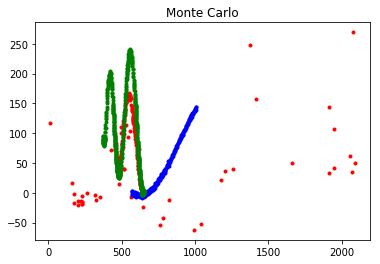

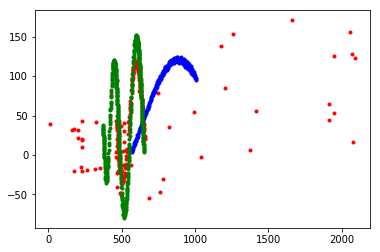

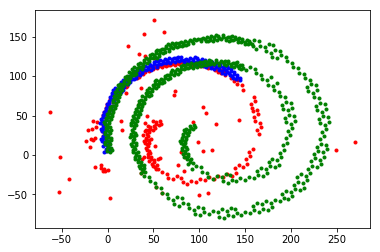

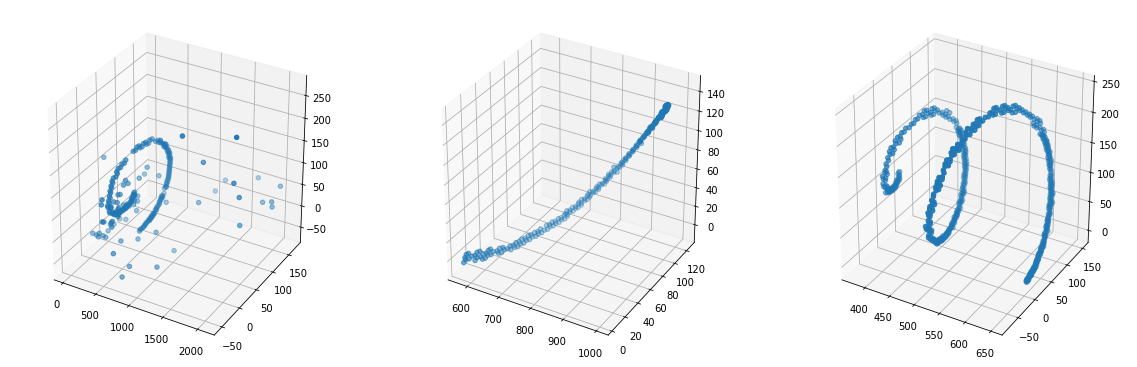

In [75]:
%matplotlib inline
plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 5], 'g.')
plt.title("Monte Carlo")
plt.show()
plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 6], 'g.')
plt.show()
plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.')
plt.plot(cut_sim_uvw_values[:, 5], cut_sim_uvw_values[:, 6], 'g.')
plt.show()


fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5])

ax3 = fig.add_subplot(2, 3, 3, projection='3d')
ax3.scatter(cut_sim_uvw_values[:,7],cut_sim_uvw_values[:,6],cut_sim_uvw_values[:,5])